In [1]:
pip install keras-tuner


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 167 kB 76.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python-headless


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install imgaug


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 948 kB 68.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 101.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import pandas as pd
import cv2
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB2
from keras import backend as K

# Load train dataset
train_df = pd.read_csv('data/training_norm.csv')
train_images = []
for image_id in train_df['image_id']:
    image = cv2.imread(f'data/training_data/training_data/{image_id}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    train_images.append(image)
train_images = np.array(train_images)
train_angles = np.array(train_df['angle'])
train_speeds = np.array(train_df['speed'])

# Load test dataset
test_images = []
for i in range(1, 1021):
    image = cv2.imread(f'data/test_data/test_data/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
test_images = np.array(test_images)
test_ids = np.arange(1, 1021)

# Build the model with EfficientNetB2
def build_model():
    base_model = EfficientNetB2(include_top=False, input_shape=(240, 320, 3), weights='imagenet')

    # freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.5)(x)

    # output layer
    angle_output = Dense(units=1, name='angle_output')(x)
    speed_output = Dense(units=1, name='speed_output')(x)
    model = Model(inputs=base_model.input, outputs=[angle_output, speed_output])

    # compile the model
    optimizer = Adam(learning_rate=1e-4)
    loss = {'angle_output': 'mean_squared_error', 'speed_output': 'mean_squared_error'}
    metrics = {'angle_output': ['mae', 'mse', r_squared], 'speed_output': ['mae', 'mse', r_squared]}
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

# Perform K-Fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_number = 0

for train_index, val_index in kfold.split(train_images, train_df[['angle', 'speed']].values):
    fold_number += 1
    print(f'Fold {fold_number}/{num_folds}')

    # Create the training and validation sets
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_df[['angle', 'speed']].values[train_index], train_df[['angle', 'speed']].values[val_index]

    # Train the model for the current fold
    model = build_model()
    history = model.fit(X_train, {'angle_output': y_train[:, 0], 'speed_output': y_train[:, 1]}, epochs=100, batch_size=32, verbose=1,
                        validation_data=(X_val, {'angle_output': y_val[:, 0], 'speed_output': y_val[:, 1]}),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1)])

# Train the model
model = build_model()
X_train, X_val, y_train, y_val = train_test_split(train_images, train_df[['angle', 'speed']].values, test_size=0.2, random_state=42)
history = model.fit(X_train, {'angle_output': y_train[:, 0], 'speed_output': y_train[:, 1]}, epochs=100, batch_size=32, verbose=1,
                    validation_data=(X_val, {'angle_output': y_val[:, 0], 'speed_output': y_val[:, 1]}),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1)])



Fold 1/5
Epoch 1/100
345/345 [==============================] - 29s 66ms/step - loss: 0.9947 - angle_output_loss: 0.4316 - speed_output_loss: 0.5632 - angle_output_mae: 0.4837 - speed_output_mae: 0.5701 - val_loss: 0.2651 - val_angle_output_loss: 0.0843 - val_speed_output_loss: 0.1808 - val_angle_output_mae: 0.2365 - val_speed_output_mae: 0.3688
Epoch 2/100
345/345 [==============================] - 22s 64ms/step - loss: 0.5370 - angle_output_loss: 0.1728 - speed_output_loss: 0.3642 - angle_output_mae: 0.3124 - speed_output_mae: 0.4896 - val_loss: 0.3644 - val_angle_output_loss: 0.0680 - val_speed_output_loss: 0.2963 - val_angle_output_mae: 0.2144 - val_speed_output_mae: 0.4399
Epoch 3/100
345/345 [==============================] - 20s 59ms/step - loss: 0.4424 - angle_output_loss: 0.1426 - speed_output_loss: 0.2998 - angle_output_mae: 0.1910 - speed_output_mae: 0.4677 - val_loss: 0.3029 - val_angle_output_loss: 0.1034 - val_speed_output_loss: 0.1995 - val_angle_output_mae: 0.1506 - val

KeyError: 'angle_output_r_squared'

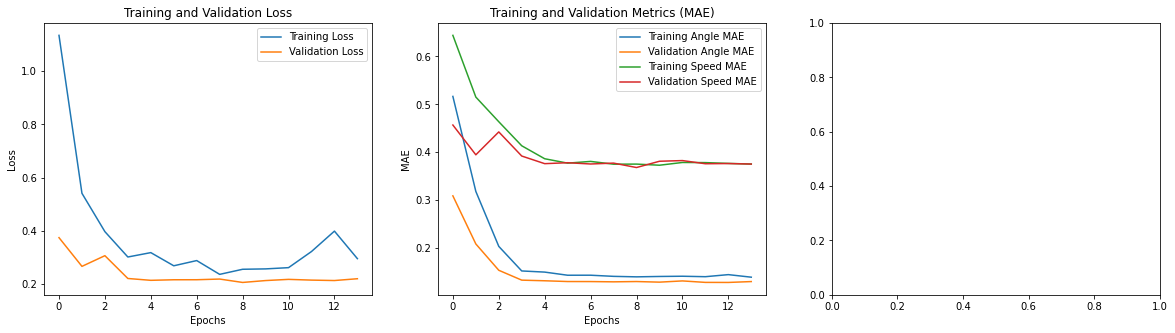

In [20]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the metrics (example with Mean Absolute Error)
    ax2.plot(history.history['angle_output_mae'], label='Training Angle MAE')
    ax2.plot(history.history['val_angle_output_mae'], label='Validation Angle MAE')
    ax2.plot(history.history['speed_output_mae'], label='Training Speed MAE')
    ax2.plot(history.history['val_speed_output_mae'], label='Validation Speed MAE')
    ax2.set_title('Training and Validation Metrics (MAE)')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.legend()

    # Plot the R-squared metric
    ax3.plot(history.history['angle_output_r_squared'], label='Training Angle R-squared')
    ax3.plot(history.history['val_angle_output_r_squared'], label='Validation Angle R-squared')
    ax3.plot(history.history['speed_output_r_squared'], label='Training Speed R-squared')
    ax3.plot(history.history['val_speed_output_r_squared'], label='Validation Speed R-squared')
    ax3.set_title('Training and Validation Metrics (R-squared)')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R-squared')
    ax3.legend()

    plt.show()

plot_learning_curves(history)


In [19]:
# Make predictions on the test set
test_predictions = model.predict(test_images)

# Get the steering angle and speed predictions separately
test_steering_predictions = test_predictions[0]    
test_speed_predictions = test_predictions[1]

# Save the submission dataframe as a CSV file
submission_df.to_csv('submission effnet with imguag and K-fold.csv', index=False)